# Reinforcement Learning

### Prashant Madaan

# I. Overview

The objective of this  is notebook is to learn and apply reinforcement learning methodologies. Reinforcement learning is very simmilar to how humans and animals learn. We reward the desired behviour or punish the undesired behaviour.A simple example would be if a child completes homework before bedtime gets a treat. Some common terminologies in RL are:

1. Reward: This is a feedback signal to the agent to indicate how good or bad is the agent performing.
2. State: Represents the curent and future/past states of a problem.
3. Action: The agent performs certain action that change the environment or the state. 
4. Policy: This defines a statergy for chosing an action given a state to maximize the rewards earned by the agent.

We learnt about the MDP model and various ways to solve them. We also learnt about the TD learning methods. In this assignment, we are solving the Maze Problem.


We will be using Q learning to solve these problems. Q learning is an app

# Maze Problem

### Description: The Maze Problem and Grid World
The Maze problem is a Grid problem where an agent is given a starting point in a 2D matrix and has to reach the goal.The agent  can reach the goal by navigating through various cells. Each cell represents a state and is given by the X and Y coordinate of the matrix.The cells of Grid World can be of the following three types:
1. Open Cells: The open cells are free for the agent to roam around without a penality.
2. Obstable Cells: If the agent runs into one of these cells, then the agent has to pay a penality.
3. Goal Cell: This cell represents the location of the Goal node for the problem.

In order to reach the goal, the agent can take one of the following actions availabe depending on the current state:
1. Go left
2. Go right 
3. Go Up 
4. Go Down
Note: The actions are limited near a boundary. For example the agent cannot take action up and left when in cell 0,0.

Rewards and Punishments are given as mentioned below:
1. The agent is awarded -1 for every step it takes.
2. The agent is awared -5 if the agent goes to a cell with obstacle or runs into a boundary.
3. The agent is awarded +30 points on reaching the goal state.

An agents needs to be trained which can find the optimum path to the goal state from any start point in the Grid World.

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

### GridWorld Class


The Gridworld class provides an environment for the Maze game and forms the basis for the agent to be trained on. The class reads the Grid file to upload the type of grid and identify various types of cells. The class also defines the permissible moves in the grid and the rewards as the agent navigates

The <b>next function</b> takes the action that agent wants to take and generates the next state using this action. This function also returns the appropriate award as per the new state generated.

In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## Sarsa and Q Learning Methods

Both Sarsa and Q learning methods are TD learning approaches. In both the methods we update the Q table. This Q table is used for the policy and decide which action to take. Basically we train  our model to update Q table. Now in Sarsa learning, we update the Q with assumption that we follow a certain behavior policy. This Sarsa is called an "On Policy" control method.
The Q table for Sarsa is updated as:
                               
                               Q(st,at)←Q(st,at)+α(Rt+1+γQ(st+1,at+1)−Q(st,at))
                                
In the Q learning method,without making assumption of behavior policy, we can explore other possible policies to update the Q. Thus Q learning method is called an Off policy control method. The Q table is updated in the Q learning apprach as the following: 

                                Q(st,at)←Q(st,at)+α(Rt+1+γmaxaQ(st+1,a)−Q(st,at))

## Sarsa vs Q Learning:
1. In Q learning we update the Q Table with action from the maximum estimate of possible next actions, regardless of which action you took.
2. Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring.
3. SARSA approaches convergence  while allowing for possible penalties arising from the  exploratory moves, while Q-learning  ignores them. That makes SARSA more conservative i.e. if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path.

## Implementation of Q Learning in RLAgent for Maze
To implement Q learning we following the following steps:
1. Initialize the Q table with the dimensions of the state space cross actions in the init method.
2. Write the greedy function. This function returns the choice of greedy action for a particular state. This is done by np.argmax(Q[s[0],s[1],:]).
3. Write the epsilon_greed function. This function plays the role of deciding and exploratory action or greedy action by generating a random value and comparing it with Epsilon.After that it returns an appropriate value. 
4. In the train function, we run a for loop which defines the maximum iterations i.e. the number of times the game wull be played. Then inside we define another for loop which runs for maximum number of steps. This loop breaks as soon as the goal state is reached.Inside the loop we take the current decided action and then calculate the next state and action. The actions are calculated by calling the epsilon_greed function. After we have calculate the next state and action, we update the Qtable with the Q learning method equation. After the updation we check if we have reached the goal state. If we have , we break the loop and the grame restarts. We also update the action and state with the next action and state values and do this all over till the goal is reached or the max steps run out. 
5. In the test function we do something simmilar to train function but some of the major difference are that the action is decided by calling the greed function on the trained Q table and the Q table is no longer updated.

In [6]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def greedy(self,Q, s):
        return np.argmax(Q[s[0],s[1],:])  # greedy action selection

    def epsilon_greed(self, epsilon, s):
        # TODO: Finish this function
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(self.Q,s)
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.3)
        maxiter= params.pop('maxiter', 100) 
        maxstep= params.pop('maxstep', 10000)
        decay=1/maxiter
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)
            
            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1], a] += alpha * (r + gamma * np.max(self.Q[s1[0],s1[1], :]) - self.Q[s[0],s[1],a])
               # print("s: ", s, "a: ", "s1:", s1, "a1:", a1, "Q: ", self.Q[s[0],s[1],a])
                
                if self.env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
            epsilon=epsilon-decay

        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=10000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        s = start
        print("Value of start is", start)
        print("environment current state",  self.env._s[0],self.env._s[1])
        self.env._s=np.asarray(start)
        a= self.env.get_cur_state
        print("environment current state",  self.env._s[0],self.env._s[1])
        print("Starting state is",s)
        print("Q table for current S", self.Q[s[0],s[1],:])
        trace = np.array(coord_convert(s, self.size))
        a=np.argmax(self.Q[s[0],s[1],:])
        print("Starting action is",a)
        for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = np.argmax(self.Q[s1[0],s1[1],:])
                print("s1 is ",s1," and a1 is ",a1)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                
                if self.env.is_goal(): # reached the goal
                    print("Reached the goal")
                    break

                s = s1
                a = a1
        
        return trace            
    


### Utility functions for Plotting

In [7]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    # TODO: plot steps
    
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

In [8]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)

print("Total Reward value: ",np.sum(rtrace))
print("Max reward Obtained:",np.max(rtrace))

Total Reward value:  -41613
Max reward Obtained: 20


<b> Testing with aplha=0.1

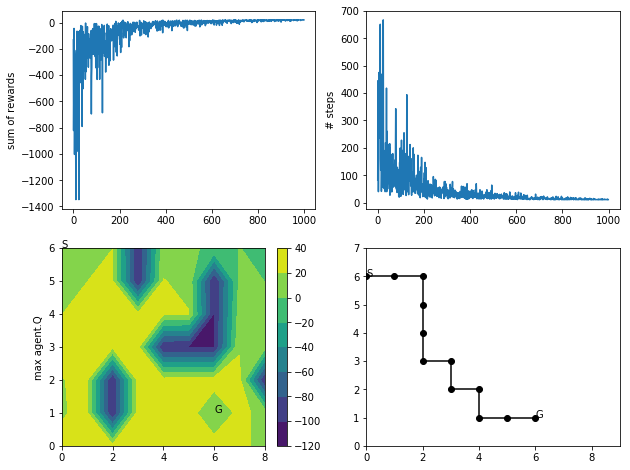

In [9]:
plot_train(agent, rtrace, steps, trace, start)

Value of start is [0, 2]
environment current state 5 6
environment current state 0 2
Starting state is [0, 2]
Q table for current S [17.56966659 14.75724178 14.75723966 19.95681028]
Starting action is 3
s1 is  [1 2]  and a1 is  3
s1 is  [2 2]  and a1 is  3
s1 is  [3 2]  and a1 is  1
s1 is  [3 3]  and a1 is  3
s1 is  [4 3]  and a1 is  1
s1 is  [4 4]  and a1 is  3
s1 is  [5 4]  and a1 is  1
s1 is  [5 5]  and a1 is  1
s1 is  [5 6]  and a1 is  0
Reached the goal


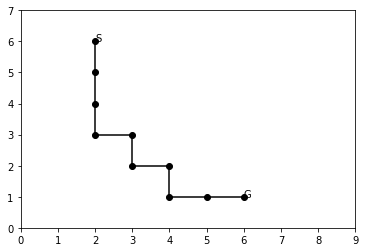

In [10]:
test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

Value of start is [1, 8]
environment current state 5 6
environment current state 1 8
Starting state is [1, 8]
Q table for current S [-0.15328546 -6.47618915 -3.4593536  -1.88062556]
Starting action is 0
s1 is  [1 7]  and a1 is  3
s1 is  [2 7]  and a1 is  3
s1 is  [3 7]  and a1 is  3
s1 is  [4 7]  and a1 is  0
s1 is  [4 6]  and a1 is  3
s1 is  [5 6]  and a1 is  0
Reached the goal


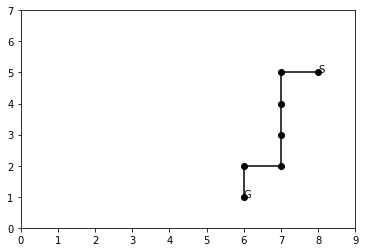

In [11]:
test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

Total Reward value:  -46027
Max reward Obtained: 20


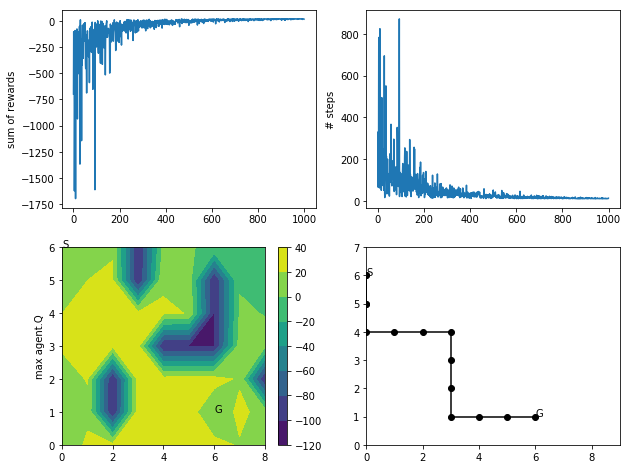

In [12]:
start = [0,0]
agent1 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent1.train(start, 
                                   gamma=0.99, 
                                   alpha=0.05, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)

plot_train(agent1, rtrace1, steps1, trace1, start)


print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))


<b> Testing with aplha=0.5

Total Reward value:  -44541
Max reward Obtained: 20


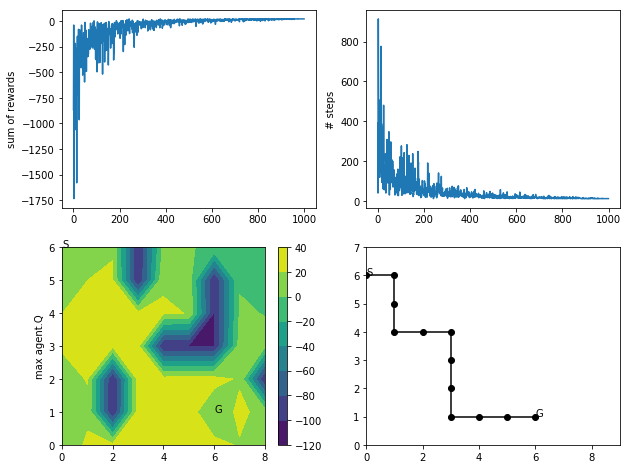

In [13]:
agent2 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent2.train(start, 
                                   gamma=0.99, 
                                   alpha=0.15, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)

plot_train(agent1, rtrace1, steps1, trace1, start)


print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))


<b> Testing with aplha=0.15

Total Reward value:  -46398
Max reward Obtained: 20


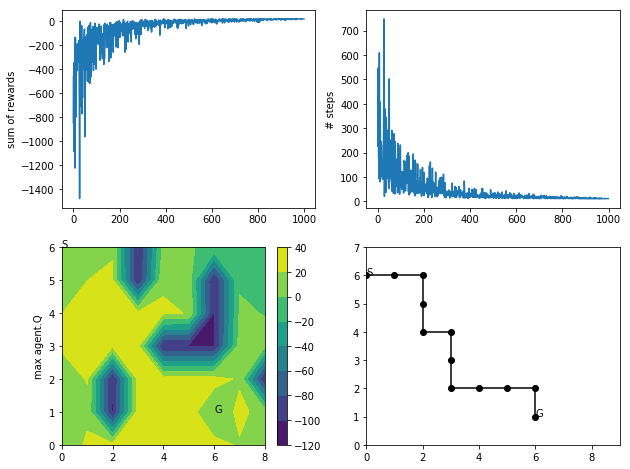

In [14]:
agent3 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent3.train(start, 
                                   gamma=0.99, 
                                   alpha=0.3, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)

plot_train(agent1, rtrace1, steps1, trace1, start)


print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))

<b> Testing with aplha=0.1

<b>As we can see from above the alpha 0.15 is giving the best reults.
    Now Trying values of gamma

Total Reward value:  -48718
Max reward Obtained: 20


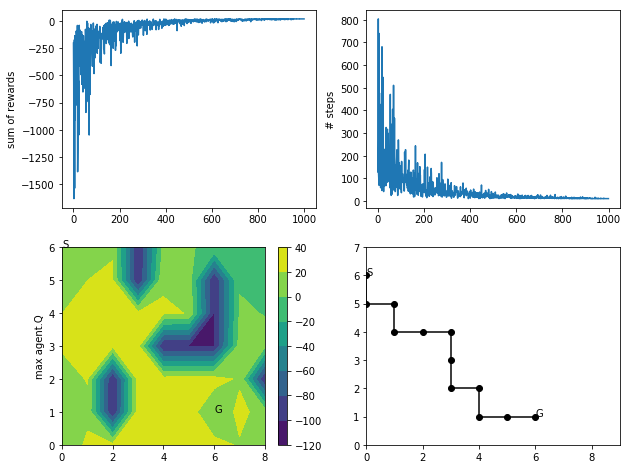

In [15]:
agent6 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent6.train(start, 
                                   gamma=0.60, 
                                   alpha=0.15, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)

plot_train(agent1, rtrace1, steps1, trace1, start)


print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))

<b> Testing with gamma=0.6

Total Reward value:  -45198
Max reward Obtained: 20


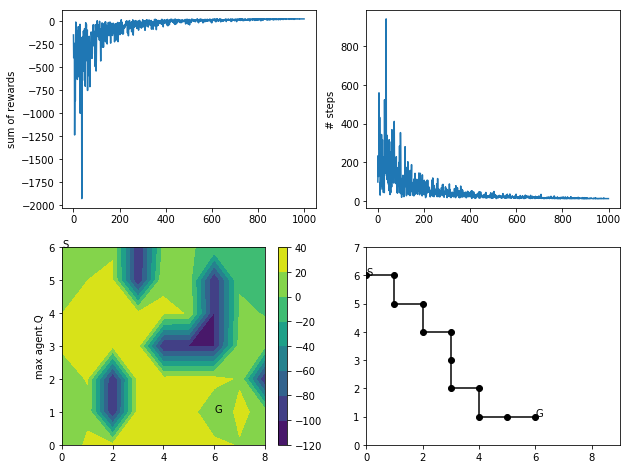

In [16]:

agent7 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent7.train(start, 
                                   gamma=0.30, 
                                   alpha=0.15, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)
 
plot_train(agent1, rtrace1, steps1, trace1, start)
print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))

<b> Testing with gamma=0.3

Total Reward value:  -47063
Max reward Obtained: 20


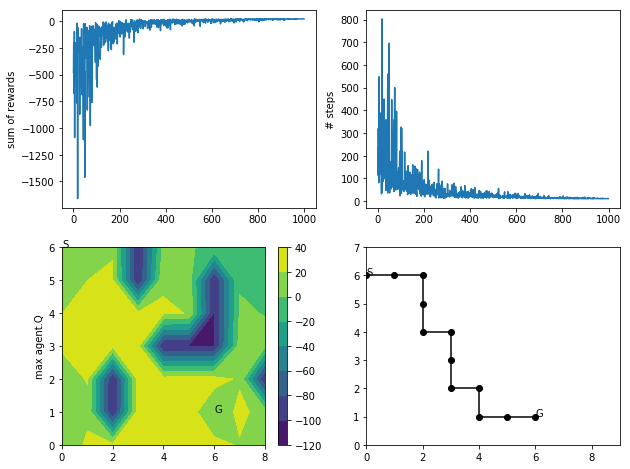

In [17]:
agent8 = RLAgent(env)
start = [0,0]
rtrace1, steps1, trace1 = agent8.train(start, 
                                   gamma=0.10, 
                                   alpha=0.15, 
                                   epsilon=1.0, 
                                   maxiter=1000, 
                                   maxstep=1000)
 
plot_train(agent1, rtrace1, steps1, trace1, start)


print("Total Reward value: ",np.sum(rtrace1))
print("Max reward Obtained:",np.max(rtrace1))

<b> Testing with gamma=0.1

## Choice of Parameters for Maze Problem
As per the experiments conducted above, following paramets are chosen.
1. Epsilon=1.0 We are chosing this as 1 as we are using a decay function
2. Alpha=0.15
3. Gamma=0.99

We are chosing the paraments on the basis of the sum of the rewards they accumulate though the entire training run.

## Analysis of learning Results:
1. The exploration rate highly effects how the agent behaves. If the agent acts more greedy then the test does not work from the points in the other portion of matrix than trained start point. 
2. As the value of Gamma decreases the accumulated award decreases. 
3. The rewards dips at first due to high exploration rate but remain stable after certain threshold indicating that the agent is learning to play the game. 
4. The number of steps taken to reach the goal are high in the begining but  then decrease as the agent learns. 
5. The value of aplha below and above 0.15 gives wrose results. 

# V. Conclusions

1. We have implement agents for the maze problem with Q learning approach.
2. The Epsilon paramter causes a huge tradeoff in the quality of learning. Thus a decay method was used.


## References
1. https://stats.stackexchange.com/questions/326788/when-to-choose-sarsa-vs-q-learning
2. https://medium.freecodecamp.org/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe